<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
from re import VERBOSE
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S, p):  # S is the matrix such that ||S^(-1) @ Dx||\leq delta. As a consequence, S appears in the unconstrained problem
        m, n = X.shape
        q = compute_q(p)
        print("who is q in AdversarialTraining: ", q)
        # Formulate problem
        param = cp.Variable(n)
        #print("shape param ", param.shape)
        #print("dim ", n)
        #print(S.shape)
        #print("S ", S)
        partial = S @ param  # should be (m * n,)
        if S.shape == (n, n):
          print("one matrix in input, S.shape = (n, n)")
          param_norm = cp.pnorm(partial, p=q)
        else:  # should be a stack of matrix
          print("multiple matrices in input, S conc")
          partial = cp.reshape(partial, (m, n), order='C')
          param_norm = cp.pnorm(partial, p=q, axis=1)
        adv_radius = cp.Parameter(name='adv_radius', nonneg=True)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / m * cp.sum((abs_error + adv_radius * param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius = adv_radius
        self.param = param
        self.warm_start = False


    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []


def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T


def plot_coefs(alphas, coefs, ax):
    #print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).sum(axis=0)
    ax.set_xlabel("1/alphas")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.semilogx(1/alphas, l1norm, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    #print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).mean(axis=0)
    l1norm = np.abs(coefs).sum(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    ax.set_xlabel("l1norm")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def train_and_plot(X, y, S, list_ax):
    linfadvtrain = AdversarialTraining(X, y, S, p=np.inf)
    estimator = lambda X, y, a:  linfadvtrain(adv_radius=a)
    alphas_adv, coefs_advtrain_linf  = get_path(X, y, estimator, 1e1)
    plot_coefs_l1norm(coefs_advtrain_linf, list_ax[0])
    plot_coefs(alphas_adv, coefs_advtrain_linf, list_ax[1])
    return alphas_adv, coefs_advtrain_linf


def add_rectangles(x, y, box_width, box_height, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)
  for xi, yi in zip(x[r_c], y[r_c]):
      rect = patches.Rectangle(
        (xi-box_width/2, yi-box_height/2),
        box_width, box_height,
        linewidth=1, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)


print("end block")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']
end block


In [78]:
# imputation's block

def clear_dataset(X, y, masks):
  # remove observations full NaN
  # X is an (n, d) matrix, y is a (n,) vector,
  # masks is an (n, d) binary matrix associated to X. 1 missing, 0 seen
  M = np.sum(1 - masks, axis=1) > 0
  M_col = np.sum(1 - masks, axis=0) > 0  # True if in the column there is at least one seen component
  if np.sum(M_col) < masks.shape[1]:
    print("Careful, there is one column full of nan")
  return X[M, :][:, M_col], y[M], masks[M, :][:, M_col]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       if nbr_mi == 1:
        res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp


def listwise_delection(X, masks):
  # masks: 1 missing, 0 seen
    M = np.sum(masks, axis=1) == 0  # zeros components are the one with full entries
    ret = X[M, :] if X.ndim == 2 else X[M]
    return ret


In [79]:
#np.random.seed(42)

#p_miss_2d = [0.2, 0.4, 0.4]
#beta_2d = np.array([0.5, 2])  # ground truth

from sklearn.datasets import make_moons, make_circles
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split

def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks

def best_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  score = np.mean(r * r, axis=1)
  i_min = np.argmin(score)
  return coeff[:, i_min], score[i_min]

def best_idx_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  score = np.mean(r * r, axis=1)
  i_min = np.argmin(score)
  return i_min, score[i_min]



def generate_X(data, dim):
    if data == 'Gaussian':
      def generator(n):
        return np.random.randn(n, dim)
    elif data == 'Uniform':
      def generator(n):
        return np.random.rand(n, dim)
    elif data == 'moons':
      def generator(n):
        return make_moons(n, noise=0.1)[0]
    elif data == 'circles':
      def generator(n):
        return make_circles(n, noise=0.1, factor=0.4)[0]
    return generator


In [83]:
# experiment 2d with dataset generated externally

def imputations(info, X_nan, y):
  # info contains the method and possible extra information
  # X_nan is the dataset with nan in place of the missing components
  # y is return as it is, unless the method require to change it, like in
  # listwise deletion
    mask_from_X_nan = np.isnan(X_nan).astype(int)
    if info['imp_method'] == 'BR_si':  # Baeysian_Ridge_single_imputation
        X = single_imputation(X_nan, BayesianRidge())
    elif info['imp_method'] == 'mi':
        X = multiple_imputation(info['mi_nbr'], X_nan)
    elif info['imp_method'] == 'l_d':  # listwise_deletion
        #mask_from_X_nan = np.isnan(X_nan).astype(int)
        X = listwise_delection(X_nan, mask_from_X_nan)
        y = listwise_delection(y, mask_from_X_nan)
        mask_from_X_nan = np.zeros_like(X)
    return X, y, mask_from_X_nan


def cov_strategy(info, dict_observations):
    X_imputed = dict_observations['X_imputed']
    X_nan = dict_observations['X_nan']
    masks = dict_observations['masks']
    if info['cov_strategy'] == 'sd':
      sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    if info['cov_strategy'] == 'eye':
      S = np.eye(X_imputed.shape[1])
    if info['cov_strategy'] == 'lounici':
      mu = np.nanmean(X_nan, axis=0)
      print("means ", mu)
      delta = 1 - np.mean(masks) # parameter missingness
      print("delta ", delta)
      X_0 = np.nan_to_num(X_nan - mu)  # check if this is correct
      print("nbr obs", X_0.shape[0])
      S =  X_0.T @ X_0 / X_0.shape[0]
      S = (1/delta - 1/(delta**2)) * np.diag(np.diag(S)) + 1/(delta**2) * S
      #S = np.diag(S)
      #mu = np.mean(X_imputed, axis=0)
      #sigma = np.cov(X_imputed, rowvar=False)
    return S


def generate_dataset(data, n_tot, dim, beta_gt, perc_test, p_miss, err):
    if data == 'Gaussian':
      X_complete = np.random.randn(n_tot, beta_gt.size)
    elif data == 'Uniform':
      X_complete = np.random.rand(n_tot, dim)
    elif data == 'moons':
      X_complete = make_moons(n_tot, noise=0.1)[0]
    elif data == 'circles':
      X_complete = make_circles(n_tot, noise=0.1, factor=0.4)[0]

    if err['type'] == 'Gaussian':
      #print("---> you have entered in GAUSSIAN ERROR ", "scaling : ", err['scaling'])
      error = np.random.randn(n_tot) * err['scaling']
    elif err['type'] == 'Uniform':
      error = (np.random.rand(n_tot)-0.5) * err['scaling']

    y_complete = X_complete @ beta_gt + error  #np.random.randn(n_tot) * err  # (np.random.rand(n_tot) - 0.5) * err
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)
    n_train = X_train.shape[0]
    masks_train = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    #M = np.sum(masks, axis=1)  # M[i] > 0 iff i has missing component
    dict_obs = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'masks_train': masks_train}
    return dict_obs


def experiment_2d_ext_dataset(dict_obs, dict_imp, ax):
    # dict_obs contains info on the observations, i.e. train, test, masks
    # dict_imp contains info on the imputation an covariance methods used,
    # dict_imp = {'imp_method': , 'cov_strategy': , .... }
    # ax contains info for the plots

    X_test = dict_obs['X_test']
    y_test = dict_obs['y_test']
    mask = dict_obs['masks_train']

    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component

    X_nan_train = dict_obs['X_train'].copy()
    X_nan_train[mask == 1] = np.nan
    #print("dict imp -----> ", dict_imp)
    X_train, y_train, mask_train = imputations(dict_imp, X_nan_train, dict_obs['y_train'])
    n_train, n_test = X_train.shape[0], X_test.shape[0]
    M = np.sum(mask_train, axis=1)  # M[i] > 0 iff i has missing component
    print("-------> size train set  : ", n_train, "  size test: ", n_test)
    print("-------> nbr_seen (train): ", np.sum(M == 0), " nbr_miss : ", np.sum(M > 0))
    #print("M size ", M.size)
    #print("M ", M)
    dict_cov = {'X_imputed': X_train, 'X_nan': X_nan_train, 'masks': mask_train}
    S = cov_strategy(dict_imp, dict_cov)
    print("----------> diag matrix: ", np.diag(S))

    alphas_used, coeff_results = train_and_plot(X_train, y_train, S, [ax[1], ax[2]])

    idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
    best_coeff, best_alpha = coeff_results[:, idx_best], alphas_used[idx_best]
    print("y_test shape ", y_test.shape)
    print("X_test shape, ", X_test.shape)
    print("best idx ", idx_best)
    print("best coeff ", best_coeff)
    print("best 1/alpha ", 1 / best_alpha)
    print("min score ", min_score)

    plt.tight_layout()
    #print(X_br_train[M == 0, 0])
    ax[0].scatter(X_train[M == 0, 0], X_train[M == 0, 1])
    ax[0].scatter(X_train[M == 1, 0], X_train[M == 1, 1])
    ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_seen: ' + str(np.sum(M == 0)) + " nbr_miss: " + str(np.sum(M > 0)))
    #
    add_rectangles(X_train[:, 0], X_train[:, 1], S[0, 0] * best_alpha, S[1, 1] * best_alpha, ax[0])

    return best_coeff, min_score, -np.log10(best_alpha)



In [146]:

def run_experiments(dictio, methods_strategy):  # ---------------------> new
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
  # methods_strategy = list of dictionary, each one of the form
  # {'imp_method': .., 'cov_strategy':.., extra info}

    l = len(dictio['data'])
    m = len(methods_strategy)
    nbr_iter = len(methods_strategy)
    coeff_fin = np.zeros((nbr_iter, 2, l))
    scores_fin = np.zeros((nbr_iter, l))

    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l / 2, 9 *l / 2), num='advtrain_linf_')
    fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l, 8 * m), num='advtrain_linf_')
    res = {}
    for info_imp_cov_dict in methods_strategy:
      #print("info imp cov dict ", info_imp_cov_dict)
      res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}

    for i in range(l):
      print("----------------------------------------------------------------------------------------------> iteration ", i)
      dict_obser = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])

      for idx, info_imp_cov_dict in enumerate(methods_strategy):
        print("---------------> new method tested: ", info_imp_cov_dict)
        coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, ax[(idx * 3):((idx+1)*3), i])
        r = coeff_round - dictio['beta_gt'][i]
        l2_dist = np.linalg.norm(r)
        res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['l2_dist_best_coeff_gt'].append(l2_dist)
        res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_coeff'].append(coeff_round)
        res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_score'].append(score_round)
        res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_alpha'].append(alpha_round)
    return res


def plot_res(x_axis_info, res, extra_info):
  x_axis = x_axis_info['vector']
  print("x_axis----> ", x_axis)
  l = len(x_axis)
  fig_res, ax_res = plt.subplots(1, 3, figsize=(15, 5), num='advtrain_linf_res')
  positions = range(l)
  print("res\n ", res)
  ch = ['o', 'x', '+']
  lb = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha']
  for i in range(3):
    for idx, (key, dictio) in enumerate(res.items()):
      #print(dictio)
      ax_res[i].plot(positions, dictio[lb[i]], marker=ch[idx], label=str(key))  # the marker is linked to the key (= method), different key correspond to different marker
      #ax_res[1].plot(positions, dictio[lb[idx]], marker=ch[idx], label=str(key))
      #ax_res[2].plot(positions, -np.log(dictio['best_alpha']), marker=ch[idx], label=str(key))
      #ax_res[0].xticks(positions, n_tot)  # Set custom labels for the x-axis
    ax_res[i].set_xticks(positions)         # Set the tick positions
    ax_res[i].set_xticklabels(x_axis)        # Set the labels at those positions
    ax_res[i].set_xlabel(x_axis_info['name'])
    ax_res[i].legend()
  ax_res[0].set_ylabel("||hat_Beta - Beta^*||_2")
  ax_res[1].set_ylabel("||hat_y - y||_2^2 / n_test")
  dict_err = extra_info['err'][0]
  #size_train = extra_info['n_tot'][0]
  ax_res[0].set_title("")
  n_test = extra_info['n_test'][0]
  ax_res[1].set_title("err: " + dict_err['type'] + ", scale: " + str(dict_err['scaling'])  + ", n_test: " + str(n_test))
  ax_res[2].set_ylabel("-log10(alpha)")


def make_dictionary_data(nbr_experiments, n_train, n_test, data, beta_gt, p_miss, err_dic):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  if isinstance(n_train, int):  # in case n_train is just a number
    n_train = [n_train] * nbr_experiments
  else:  # should be a list of integer
    print("change nbr_experiments to match the size of n_train")
    nbr_experiments = len(n_train)
  if isinstance(n_test, int):  # in case n_test is just a number
    n_test = [n_test] * nbr_experiments
  n_tot = [x + y for x, y in zip(n_train, n_test)]
  #print("n_total ", n_tot)
  perc_test = [x / (x+y) for x, y in zip(n_test, n_train)]
  #print("little test, should get n_test ", [z * w for z, w in zip(n_tot, perc_test)])
  dim = beta_gt.size
  #print("err \n\n\\n", err_dic)
  #print("err * nbr exp\n\n\\n", err_dic)
  dictio = {'data':[data] * nbr_experiments,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': [dim] * nbr_experiments,
        'beta_gt': [beta_gt] * nbr_experiments,
        'perc_test': perc_test,
        'p_miss': [p_miss] * nbr_experiments,
        'err': [err_dic] * nbr_experiments
        }
  return dictio



In [138]:
res = make_dictionary_data(3, 4, 5, 'gaus', np.array([1, 2]), [0.1, 0.1, 0.8], {'type':'gau', 'scaling': 5})
#print(res)
for key, value in res.items():
  print(key,": " , value)

res1 = make_dictionary_data(3, [4, 10, 20], 5, 'gaus', np.array([1, 2]), [0.1, 0.1, 0.8], {'type':'gau', 'scaling': 5})
#print(res)
for key, value in res1.items():
  print(key,": " , value)



n_total  [9, 9, 9]
little test, should get n_test  [5.0, 5.0, 5.0]
data :  ['gaus', 'gaus', 'gaus']
n_tot :  [9, 9, 9]
n_train :  [4, 4, 4]
n_test :  [5, 5, 5]
dim :  [2, 2, 2]
beta_gt :  [array([1, 2]), array([1, 2]), array([1, 2])]
perc_test :  [0.5555555555555556, 0.5555555555555556, 0.5555555555555556]
p_miss :  [[0.1, 0.1, 0.8], [0.1, 0.1, 0.8], [0.1, 0.1, 0.8]]
err :  [[{'type': 'Gaussian', 'scaling': 5}, {'type': 'Gaussian', 'scaling': 5}, {'type': 'Gaussian', 'scaling': 5}, {'type': 'Gaussian', 'scaling': 5}], [{'type': 'Gaussian', 'scaling': 5}, {'type': 'Gaussian', 'scaling': 5}, {'type': 'Gaussian', 'scaling': 5}, {'type': 'Gaussian', 'scaling': 5}], [{'type': 'Gaussian', 'scaling': 5}, {'type': 'Gaussian', 'scaling': 5}, {'type': 'Gaussian', 'scaling': 5}, {'type': 'Gaussian', 'scaling': 5}]]
change nbr_experiments to match the size of n_train
n_total  [9, 15, 25]
little test, should get n_test  [5.0, 5.0, 5.0]
data :  ['gaus', 'gaus', 'gaus']
n_tot :  [9, 15, 25]
n_train :

change nbr_experiments to match the size of n_train
n_total  [10100, 10200, 10300]
little test, should get n_test  [10000.0, 10000.0, 10000.0]
data :  ['Gaussian', 'Gaussian', 'Gaussian']
n_tot :  [10100, 10200, 10300]
n_train :  [100, 200, 300]
n_test :  [10000, 10000, 10000]
dim :  [2, 2, 2]
beta_gt :  [array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ])]
perc_test :  [0.9900990099009901, 0.9803921568627451, 0.970873786407767]
p_miss :  [[0.2, 0.4, 0.4], [0.2, 0.4, 0.4], [0.2, 0.4, 0.4]]
err :  [{'type': 'Gaussian', 'scaling': 5}, {'type': 'Gaussian', 'scaling': 5}, {'type': 'Gaussian', 'scaling': 5}]
{'data': ['Gaussian', 'Gaussian', 'Gaussian'], 'n_tot': [10100, 10200, 10300], 'n_train': [100, 200, 300], 'n_test': [10000, 10000, 10000], 'dim': [2, 2, 2], 'beta_gt': [array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ])], 'perc_test': [0.9900990099009901, 0.9803921568627451, 0.970873786407767], 'p_miss': [[0.2, 0.4, 0.4], [0.2, 0.4, 0.4], [0.2, 0.4, 0.4]], 'err': [

100%|██████████| 200/200 [00:00<00:00, 205.22it/s]


y_test shape  (10000,)
X_test shape,  (10000, 2)
best idx  0
best coeff  [-0.1298974   0.95126366]
best 1/alpha  10000.0
min score  26.15401546720556
---------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size train set  :  16   size test:  10000
-------> nbr_seen (train):  16  nbr_miss :  0
----------> diag matrix:  [1.05630089 0.96169161]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 435.89it/s]


y_test shape  (10000,)
X_test shape,  (10000, 2)
best idx  134
best coeff  [0.6408632  1.16538239]
best 1/alpha  4.297004704320839
min score  26.84889203556448
---------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size train set  :  100   size test:  10000
-------> nbr_seen (train):  16  nbr_miss :  84
----------> diag matrix:  [1.02740459 0.98942391]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:01<00:00, 151.77it/s]


y_test shape  (10000,)
X_test shape,  (10000, 2)
best idx  0
best coeff  [0.13103481 0.6526518 ]
best 1/alpha  10000.0
min score  27.060158513648442
----------------------------------------------------------------------------------------------> iteration  1
---------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size train set  :  200   size test:  10000
-------> nbr_seen (train):  43  nbr_miss :  157
----------> diag matrix:  [0.74032294 0.77724935]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:02<00:00, 90.06it/s] 


y_test shape  (10000,)
X_test shape,  (10000, 2)
best idx  91
best coeff  [-0.81586396  1.7637718 ]
best 1/alpha  51.70920242896755
min score  25.24734390343095
---------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size train set  :  43   size test:  10000
-------> nbr_seen (train):  43  nbr_miss :  0
----------> diag matrix:  [0.88765506 0.92821709]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 346.47it/s]


y_test shape  (10000,)
X_test shape,  (10000, 2)
best idx  117
best coeff  [-0.44848842  2.131613  ]
best 1/alpha  11.489510001873086
min score  25.012731441501863
---------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size train set  :  200   size test:  10000
-------> nbr_seen (train):  43  nbr_miss :  157
----------> diag matrix:  [0.97388155 0.97724557]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:01<00:00, 113.79it/s]


y_test shape  (10000,)
X_test shape,  (10000, 2)
best idx  0
best coeff  [-0.6499994   1.33323356]
best 1/alpha  10000.0
min score  25.654228639219237
----------------------------------------------------------------------------------------------> iteration  2
---------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size train set  :  300   size test:  10000
-------> nbr_seen (train):  60  nbr_miss :  240
----------> diag matrix:  [0.799246   0.77406504]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:02<00:00, 96.36it/s]


y_test shape  (10000,)
X_test shape,  (10000, 2)
best idx  0
best coeff  [0.10652178 1.509408  ]
best 1/alpha  10000.0
min score  25.404849778290426
---------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size train set  :  60   size test:  10000
-------> nbr_seen (train):  60  nbr_miss :  0
----------> diag matrix:  [1.00307361 0.97012995]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 285.77it/s]


y_test shape  (10000,)
X_test shape,  (10000, 2)
best idx  0
best coeff  [0.325022   1.24819956]
best 1/alpha  10000.0
min score  26.07124675069848
---------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size train set  :  300   size test:  10000
-------> nbr_seen (train):  60  nbr_miss :  240
----------> diag matrix:  [1.0293973  1.03676029]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:02<00:00, 73.97it/s]


y_test shape  (10000,)
X_test shape,  (10000, 2)
best idx  0
best coeff  [0.0485316 1.1346024]
best 1/alpha  10000.0
min score  25.93523651796608
x_axis---->  [100, 200, 300]
res
  {('BR_si', 'sd'): {'best_coeff': [array([-0.1298974 ,  0.95126366]), array([-0.81586396,  1.7637718 ]), array([0.10652178, 1.509408  ])], 'l2_dist_best_coeff_gt': [np.float64(1.1121258214272491), np.float64(0.3944284503137764), np.float64(0.7800956246431336)], 'best_score': [np.float64(26.15401546720556), np.float64(25.24734390343095), np.float64(25.404849778290426)], 'best_alpha': [np.float64(4.0), np.float64(1.7135678391959797), np.float64(4.0)]}, ('l_d', 'sd'): {'best_coeff': [array([0.6408632 , 1.16538239]), array([-0.44848842,  2.131613  ]), array([0.325022  , 1.24819956])], 'l2_dist_best_coeff_gt': [np.float64(1.4135612503232213), np.float64(0.14133443804571932), np.float64(1.11618331817969)], 'best_score': [np.float64(26.84889203556448), np.float64(25.012731441501863), np.float64(26.07124675069848)], 

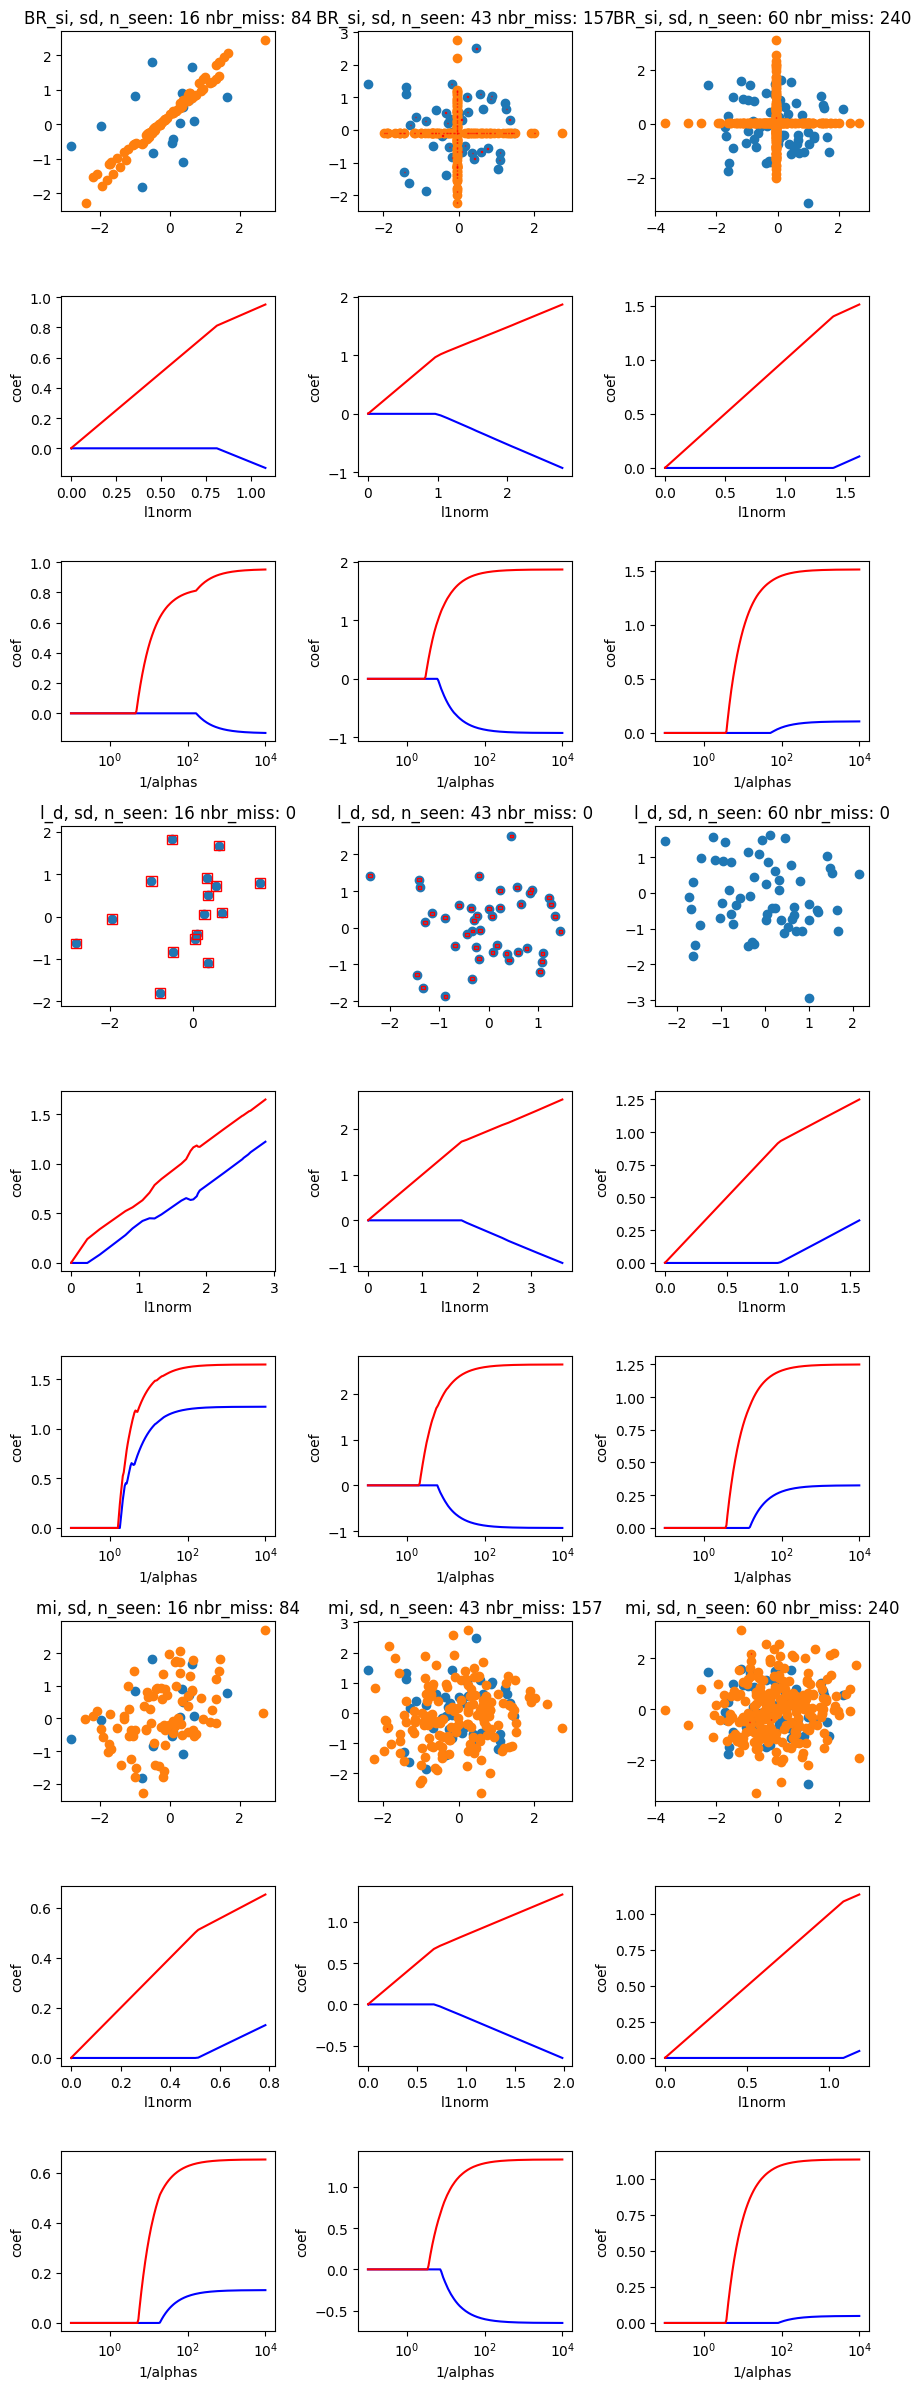

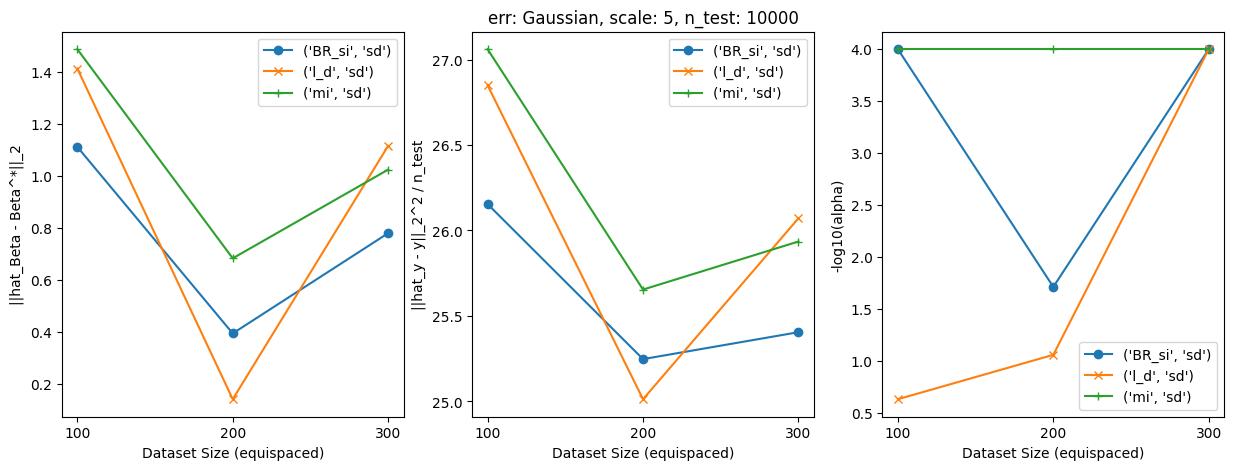

In [147]:
'''
n_train = [500, 1000, 2000, 3000]
ll = len(n_train)
n_test = [10000] * ll
n_tot = [x + y for x, y in zip(n_train, n_test)]
print("n_total ", n_tot)
perc_test = [x / (x+y) for x, y in zip(n_test, n_train)]
print("perc test ", perc_test)
data = ['Gaussian'] * ll
dim = [2] * ll
beta_gt = [np.array([-0.5, 2])] * ll
print(beta_gt)
p_miss = [[0.2, 0.4, 0.4]] * ll
print("p_missing", p_miss)
err_dic = {'type': 'Gaussian', 'scaling': 5}
err = [err_dic] * ll
dicc = {'data':data,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': dim,
        'beta_gt': beta_gt,
        'perc_test': perc_test,
        'p_miss': p_miss,
        'err': err}
'''
np.random.seed(4321)  # 43
n_train = [100, 200, 300]
dicc = make_dictionary_data(
    nbr_experiments= len(n_train), n_train = n_train, n_test=10000,
    data = 'Gaussian',
    beta_gt = np.array([-0.5, 2]),
    p_miss = [0.2, 0.4, 0.4],
    err_dic = {'type': 'Gaussian', 'scaling': 5}
)

for key, value in dicc.items():
  print(key,": " , value)

dicc_imp1 = {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
dicc_imp2 = {'imp_method': 'l_d', 'cov_strategy': 'sd'}
dicc_imp3 = {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1}

#list_methods_strategy = [dicc_imp1, dicc_imp2]
list_methods_strategy = [dicc_imp1, dicc_imp2, dicc_imp3]
print(dicc)

print("----> Starting experiments")
res = run_experiments(dicc, list_methods_strategy)

info_x_axis = {'name': 'Dataset Size (equispaced)', 'vector': n_train}
plot_res(info_x_axis, res, dicc)


n_total  [140, 140, 140, 140, 140]
perc test  [0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143]
[array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ])]
[0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143]
{'data': ['Gaussian', 'Gaussian', 'Gaussian', 'Gaussian', 'Gaussian'], 'n_tot': [140, 140, 140, 140, 140], 'n_train': [40, 40, 40, 40, 40], 'n_test': [100, 100, 100, 100, 100], 'dim': [2, 2, 2, 2, 2], 'beta_gt': [array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ])], 'perc_test': [0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143], 'p_miss': [[0.8, 0.1, 0.1], [0.6, 0.2, 0.2], [0.4, 0.3, 0.3], [0.1, 0.45, 0.45], [0.02, 0.49, 0.49]], 'err': [{'type': 'Gaussian', 'scaling': 5}, {'type': 'Gaussian', 'scaling': 5}, {'type': 'Gaussian', 'scaling'

100%|██████████| 200/200 [00:00<00:00, 345.69it/s]


y_test shape  (100,)
X_test shape,  (100, 2)
best idx  0
best coeff  [-0.58542986  2.38037273]
best 1/alpha  10000.0
min score  24.83942162026215
---------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size train set  :  28   size test:  100
-------> nbr_seen (train):  28  nbr_miss :  0
----------> diag matrix:  [0.98898917 1.38174143]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 371.93it/s]


y_test shape  (100,)
X_test shape,  (100, 2)
best idx  0
best coeff  [-0.77959222  2.55568175]
best 1/alpha  10000.0
min score  24.751369718978367
---------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size train set  :  40   size test:  100
-------> nbr_seen (train):  28  nbr_miss :  12
----------> diag matrix:  [0.94141613 1.29046131]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 314.54it/s]


y_test shape  (100,)
X_test shape,  (100, 2)
best idx  0
best coeff  [-0.32996218  2.06827031]
best 1/alpha  10000.0
min score  25.2701406031034
----------------------------------------------> iteration  1
---------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size train set  :  40   size test:  100
-------> nbr_seen (train):  25  nbr_miss :  15
----------> diag matrix:  [0.93214879 0.80963686]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 339.00it/s]


y_test shape  (100,)
X_test shape,  (100, 2)
best idx  0
best coeff  [-0.51482072  1.24413189]
best 1/alpha  10000.0
min score  29.98263783937779
---------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size train set  :  25   size test:  100
-------> nbr_seen (train):  25  nbr_miss :  0
----------> diag matrix:  [1.03761441 0.96019975]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 397.32it/s]


y_test shape  (100,)
X_test shape,  (100, 2)
best idx  0
best coeff  [-0.49050519  1.27918218]
best 1/alpha  10000.0
min score  29.915289653305173
---------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size train set  :  40   size test:  100
-------> nbr_seen (train):  25  nbr_miss :  15
----------> diag matrix:  [0.98438915 0.84119968]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 340.91it/s]


y_test shape  (100,)
X_test shape,  (100, 2)
best idx  0
best coeff  [-0.54570379  1.54301473]
best 1/alpha  10000.0
min score  29.247497604792866
----------------------------------------------> iteration  2
---------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size train set  :  40   size test:  100
-------> nbr_seen (train):  17  nbr_miss :  23
----------> diag matrix:  [0.74275613 0.64438422]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 223.81it/s]


y_test shape  (100,)
X_test shape,  (100, 2)
best idx  123
best coeff  [-2.06318511e-08  1.13230978e+00]
best 1/alpha  8.119844993184008
min score  18.251788426214866
---------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size train set  :  17   size test:  100
-------> nbr_seen (train):  17  nbr_miss :  0
----------> diag matrix:  [0.88760078 0.74516215]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 299.10it/s]


y_test shape  (100,)
X_test shape,  (100, 2)
best idx  103
best coeff  [-0.44311319  1.28625731]
best 1/alpha  25.82618760682675
min score  17.956088464277613
---------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size train set  :  40   size test:  100
-------> nbr_seen (train):  17  nbr_miss :  23
----------> diag matrix:  [0.85518166 0.75859429]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 341.05it/s]


y_test shape  (100,)
X_test shape,  (100, 2)
best idx  0
best coeff  [-0.58511492  0.91097307]
best 1/alpha  10000.0
min score  18.052993144588953
----------------------------------------------> iteration  3
---------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size train set  :  40   size test:  100
-------> nbr_seen (train):  8  nbr_miss :  32
----------> diag matrix:  [0.79032503 0.83686217]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:01<00:00, 107.56it/s]


y_test shape  (100,)
X_test shape,  (100, 2)
best idx  0
best coeff  [-0.68094157  1.8561816 ]
best 1/alpha  10000.0
min score  21.251997984832727
---------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size train set  :  8   size test:  100
-------> nbr_seen (train):  8  nbr_miss :  0
----------> diag matrix:  [0.62262565 1.41652676]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 286.87it/s]


y_test shape  (100,)
X_test shape,  (100, 2)
best idx  94
best coeff  [0.00196805 0.79259391]
best 1/alpha  43.47013158125022
min score  25.526442164813474
---------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size train set  :  40   size test:  100
-------> nbr_seen (train):  8  nbr_miss :  32
----------> diag matrix:  [0.94296485 1.06546908]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:02<00:00, 92.47it/s]


y_test shape  (100,)
X_test shape,  (100, 2)
best idx  0
best coeff  [-0.71900392  1.13019692]
best 1/alpha  10000.0
min score  22.19947355225555


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


----------------------------------------------> iteration  4
---------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
-------> size train set  :  40   size test:  100
-------> nbr_seen (train):  1  nbr_miss :  39
----------> diag matrix:  [1.00815915 1.32593463]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 338.36it/s]


y_test shape  (100,)
X_test shape,  (100, 2)
best idx  99
best coeff  [0.08486182 0.66077347]
best 1/alpha  32.550885998350566
min score  30.554992259700892
---------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'sd'}
-------> size train set  :  1   size test:  100
-------> nbr_seen (train):  1  nbr_miss :  0
----------> diag matrix:  [0. 0.]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 512.64it/s]


y_test shape  (100,)
X_test shape,  (100, 2)
best idx  167
best coeff  [1.18820449 0.69662068]
best 1/alpha  0.6368249944718586
min score  31.0590667074345
---------------> new method tested:  {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr': 1}
-------> size train set  :  40   size test:  100
-------> nbr_seen (train):  1  nbr_miss :  39
----------> diag matrix:  [1.13107895 1.19181481]
who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:01<00:00, 195.83it/s]


y_test shape  (100,)
X_test shape,  (100, 2)
best idx  0
best coeff  [-0.20461008  1.19991012]
best 1/alpha  10000.0
min score  28.82273476962739
{'name': 'perc seen', 'vector': [0.8, 0.6, 0.4, 0.1, 0.02]}
x_axis---->  [0.8, 0.6, 0.4, 0.1, 0.02]
res
  {('BR_si', 'sd'): {'best_coeff': [array([-0.58542986,  2.38037273]), array([-0.51482072,  1.24413189]), array([-2.06318511e-08,  1.13230978e+00]), array([-0.68094157,  1.8561816 ]), array([0.08486182, 0.66077347])], 'l2_dist_best_coeff_gt': [np.float64(0.3898482680848415), np.float64(0.7560133911013308), np.float64(1.001442108517201), np.float64(0.23113542807986726), np.float64(1.4613661572952414)], 'best_score': [np.float64(24.83942162026215), np.float64(29.98263783937779), np.float64(18.251788426214866), np.float64(21.251997984832727), np.float64(30.554992259700892)], 'best_alpha': [np.float64(4.0), np.float64(4.0), np.float64(0.9095477386934672), np.float64(4.0), np.float64(1.5125628140703515)]}, ('l_d', 'sd'): {'best_coeff': [array([-

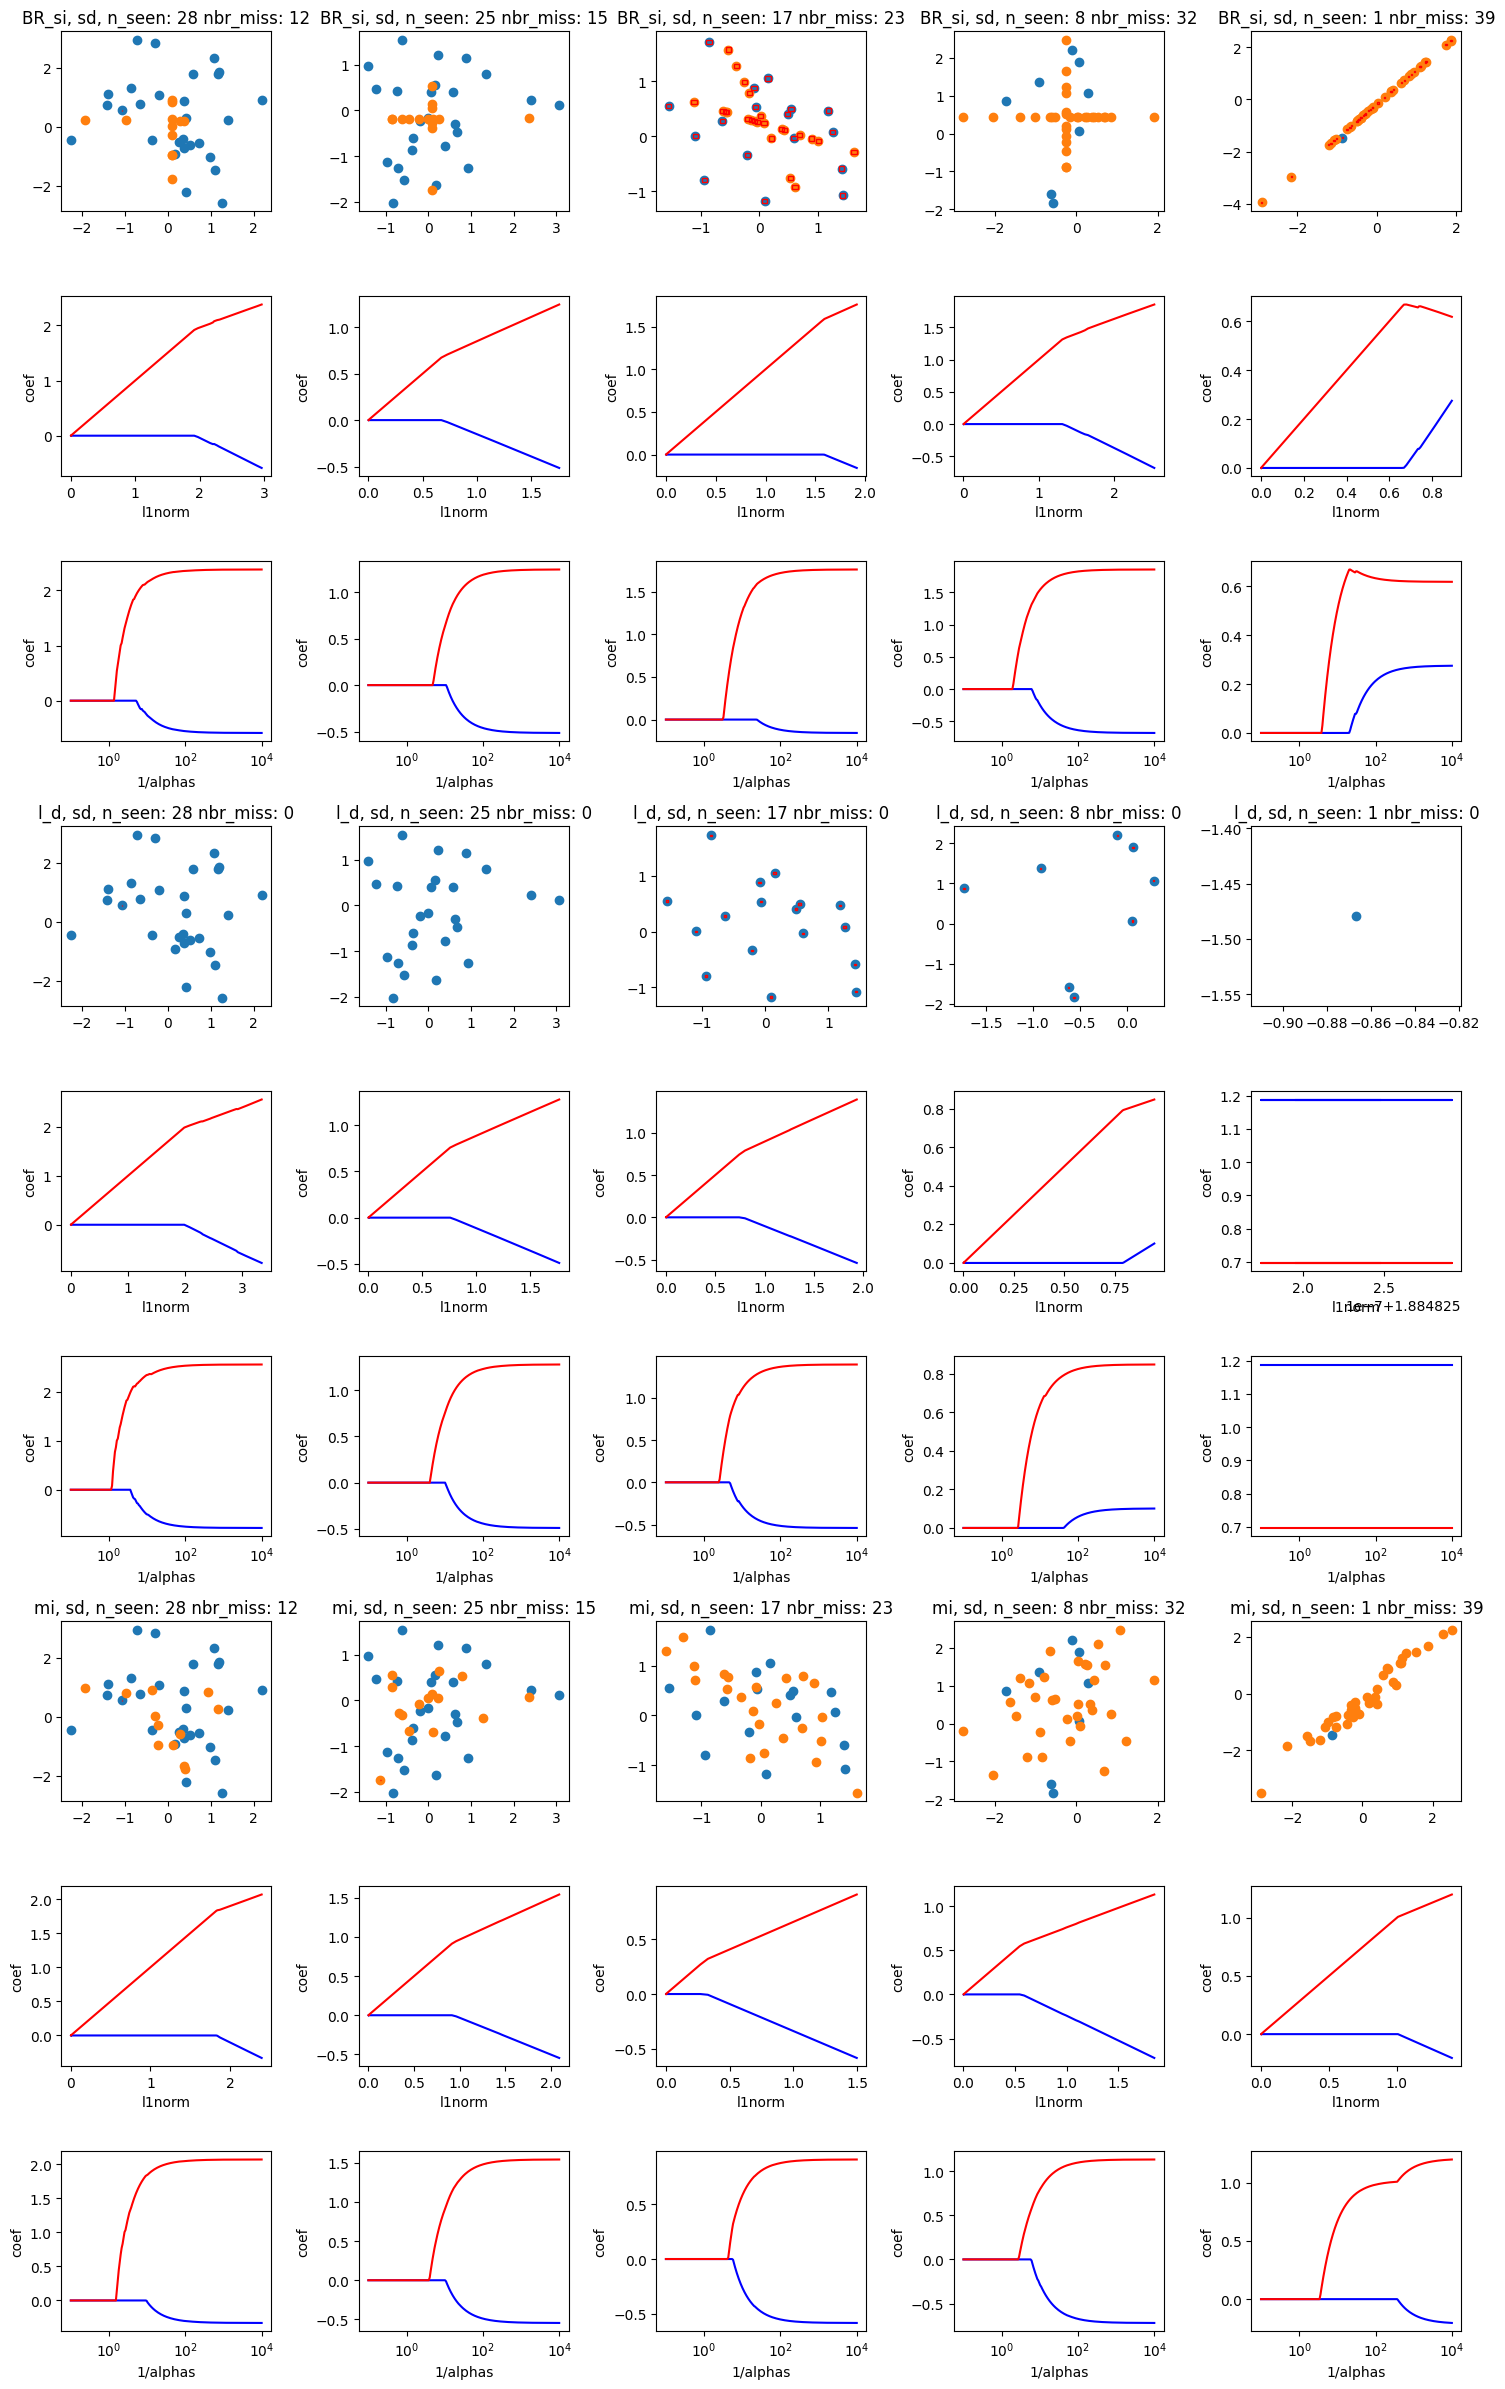

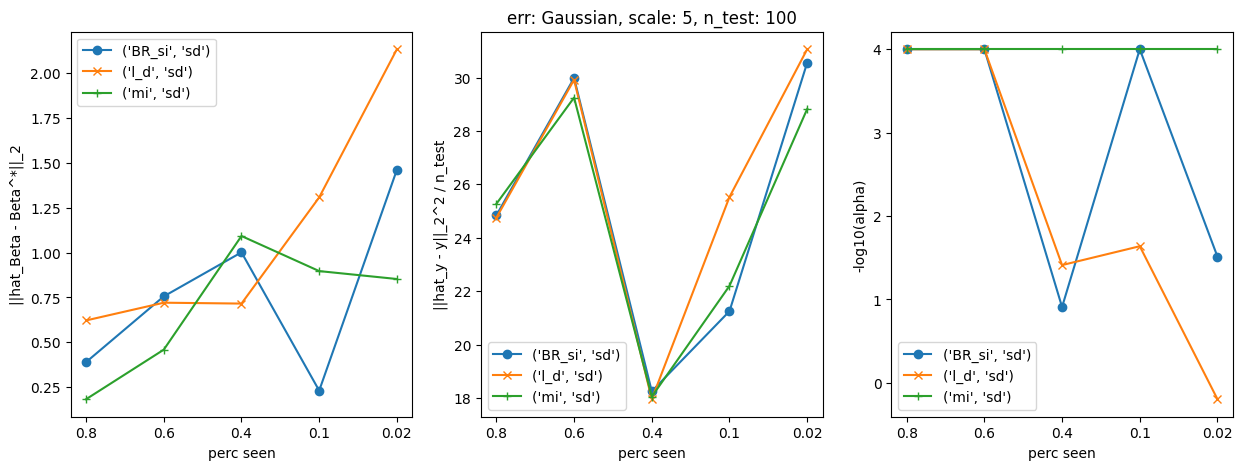

In [122]:
np.random.seed(47)  # 43
p_seen = [0.8, 0.6, 0.4, 0.1, 0.02]
p_miss = [[0.8, 0.1, 0.1], [0.6, 0.2, 0.2], [0.4, 0.3, 0.3], [0.1, 0.45, 0.45], [0.02, 0.49, 0.49]]
ll = len(p_miss)
n_train = [40] * ll # 750, 1000, 2000
n_test = [100] * ll
n_tot = [x + y for x, y in zip(n_train, n_test)]
print("n_total ", n_tot)
p_t = [x / (x+y) for x, y in zip(n_test, n_train)]
print("perc test ", p_t)
#n_tot = [1000 * 5 , 1500 * 5, 2000 * 5]  # 750, 1000, 2000
data = ['Gaussian'] * ll
#n_tot = [75, 100, 200]
dim = [2] * ll
beta_gt = [np.array([-0.5, 2])] * ll
print(beta_gt)
perc_test = p_t
print(perc_test)
err_dic = {'type': 'Gaussian', 'scaling': 5}
err = [err_dic] * ll
dicc = {'data':data,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': dim,
        'beta_gt': beta_gt,
        'perc_test': perc_test,
        'p_miss': p_miss,
        'err': err}

dicc_imp1 = {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
dicc_imp2 = {'imp_method': 'l_d', 'cov_strategy': 'sd'}
dicc_imp3 = {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1}

#list_methods_strategy = [dicc_imp1, dicc_imp2]
list_methods_strategy = [dicc_imp1, dicc_imp2, dicc_imp3]
print(dicc)

res = run_experiments(dicc, list_methods_strategy)

info_x_axis = {'name': 'perc seen', 'vector': p_seen}
print(info_x_axis)
plot_res(info_x_axis, res, dicc)


In [64]:
np.random.seed(4321)
p_seen = [0.8, 0.6, 0.4, 0.1, 0.02]
p_miss = [[0.8, 0.1, 0.1], [0.6, 0.2, 0.2], [0.4, 0.3, 0.3], [0.1, 0.45, 0.45], [0.02, 0.49, 0.49]]
ll = len(p_miss)
n_train = [40] * ll # 750, 1000, 2000
n_test = [100] * ll
n_tot = [x + y for x, y in zip(n_train, n_test)]
print("n_total ", n_tot)
p_t = [x / (x+y) for x, y in zip(n_test, n_train)]
print("perc test ", p_t)
#n_tot = [1000 * 5 , 1500 * 5, 2000 * 5]  # 750, 1000, 2000
data = ['Gaussian'] * ll
#n_tot = [75, 100, 200]
dim = [2] * ll
beta_gt = [np.array([-0.5, 2])] * ll
print(beta_gt)
perc_test = p_t
print(perc_test)
err_dic = {'type': 'Gaussian', 'scaling': 5}
err = [err_dic] * ll
dicc = {'data':data,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': dim,
        'beta_gt': beta_gt,
        'perc_test': perc_test,
        'p_miss': p_miss,
        'err': err}

dicc_imp1 = {'imp_method': 'BR_si', 'cov_strategy': 'sd'}
dicc_imp2 = {'imp_method': 'l_d', 'cov_strategy': 'sd'}
dicc_imp3 = {'imp_method': 'mi', 'cov_strategy': 'sd', 'mi_nbr':1}

#list_methods_strategy = [dicc_imp1, dicc_imp2]
list_methods_strategy = [dicc_imp1, dicc_imp2, dicc_imp3]
print(dicc)

res = run_experiments(dicc, list_methods_strategy)

info_x_axis = {'name': 'perc seen', 'vector': p_seen}
print(info_x_axis)
plot_res(info_x_axis, res, dicc)


In [ ]:
'''
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)
'''

In [ ]:
'''
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)
'''

In [ ]:
'''
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)
'''

In [ ]:
'''
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)
'''

end block


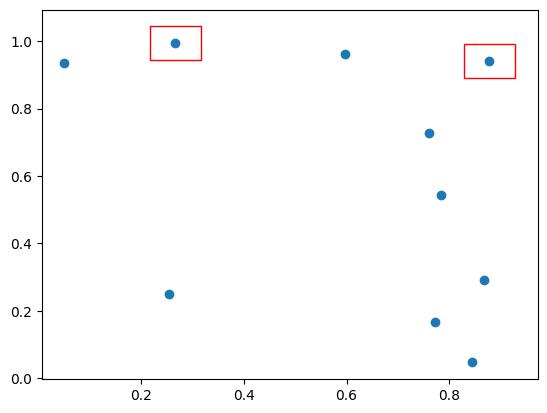

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Example data
x_test_rect = np.random.rand(10)
y_test_rect = np.random.rand(10)

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_test_rect, y_test_rect)

width = 0.1
height = 0.1

add_rectangles(x_test_rect, y_test_rect, width, height, ax)

# Add the rectangle to the plot


test generate_X started
(1000, 2)
test generate passed syccessfully

test preparation dataset started
X_train 
 [[0.80334728 0.90021154 0.43319654 0.73044707]
 [0.69379148 0.07491993 0.64905579 0.12462664]
 [0.8267034  0.16017752 0.96197793 0.72040011]]
mask, 0 seen, 1 missing 
  [[1 1 1 1]
 [1 0 0 1]
 [1 1 1 1]]
X_masked 
 [[0.         0.         0.         0.        ]
 [0.         0.07491993 0.64905579 0.        ]
 [0.         0.         0.         0.        ]]
X_nan_train 
 [[       nan        nan        nan        nan]
 [       nan 0.07491993 0.64905579        nan]
 [       nan        nan        nan        nan]]
X_br_train
  [[0.07491993 0.64905579]
 [0.07491993 0.64905579]
 [0.07491993 0.64905579]]
what happens if we run single_imputation of full dataset
X_br_full
  [[0.80334728 0.90021154 0.43319654 0.73044707]
 [0.69379148 0.07491993 0.64905579 0.12462664]
 [0.8267034  0.16017752 0.96197793 0.72040011]]
test preparation dataset ended successfully

 test list_wise delection start

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [0 3]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


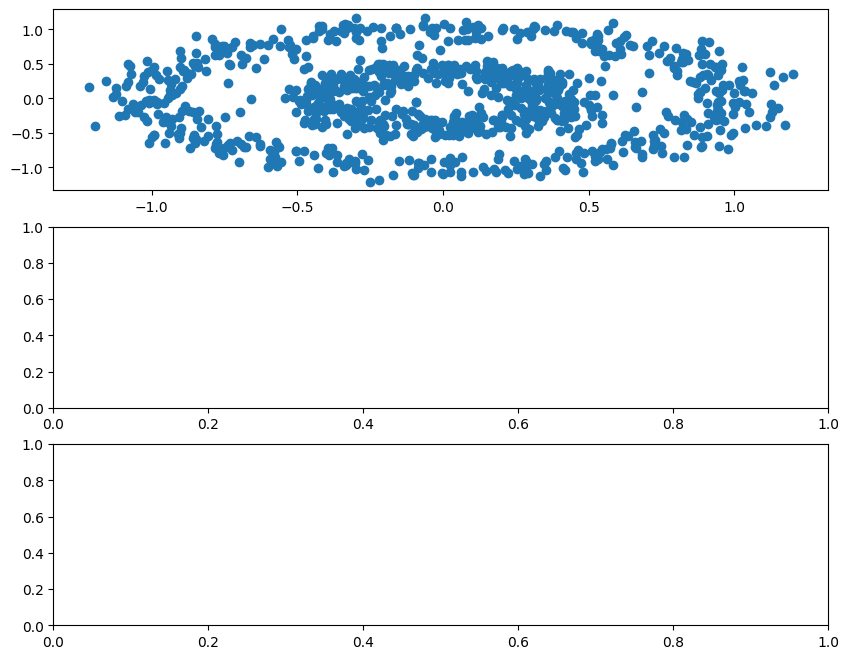

In [65]:
# Cell for some tests

def test_clear_dataset(n, d):
  print("test clear dataset")
  X = np.random.randint(1, 3, size=(n, d))
  y = np.random.randint(1, 3, size=n)
  masks = np.random.binomial(1, 0.3, size=(n, d))
  print("X \n", X)
  print("y\n", y)
  print("masks \n", masks)
  masks[:, 0] = np.ones(n)
  masks[0, :] = np.ones(d)
  X_res, y_res, masks_res = clear_dataset(X, y, masks)
  print("X_res \n", X_res)
  print("y\n", y_res)
  print("masks \n", masks_res)
  print("test clear dataset ended successfully")

def test_generate_X():
    print("test generate_X started")
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf')
    gen = generate_X('circles', 2)
    data = gen(1000)
    print(data.shape)
    ax[0].scatter(data[:, 0], data[:, 1])
    print("test generate passed syccessfully")

def test_preparation_dataset(n, d):
      print("\ntest preparation dataset started")
      X_train = np.random.rand(n, d)
      print("X_train \n", X_train)
      mask = np.random.binomial(1, 0.5, (n, d))
      print("mask, 0 seen, 1 missing \n ", mask)
      X_masked = X_train * (1 - mask)
      print("X_masked \n", X_masked)
      X_nan_train = X_train.copy()
      X_nan_train[mask == 1] = np.nan
      print("X_nan_train \n", X_nan_train)
      X_br_train = single_imputation(X_nan_train, BayesianRidge())
      print("X_br_train\n ", X_br_train)

      print("what happens if we run single_imputation of full dataset")
      X_br_full = single_imputation(X_train, BayesianRidge())
      print("X_br_full\n ", X_br_full)
      np.testing.assert_allclose(X_train, X_br_full)  # shuold be untouched
      print("test preparation dataset ended successfully")

def test_listwise_delection(n, d):
    print("\n test list_wise delection started")
    X = np.random.rand(n, d)
    print("data\n", X)
    mask = np.random.binomial(1, 0.2, (n, d))
    print("mask \n", mask)
    X_ld = listwise_delection(X, mask)
    print("after calling function, X_ld \n", X_ld)

    print("edge cases, all missing")
    mask_1 = np.ones_like(X)  # all missing
    X1 = listwise_delection(X, mask_1)
    print("X1 \n", X1)  # should be empty
    mask_0 = np.zeros_like(X)  # all seen
    X0 = listwise_delection(X, mask_0)
    print("X0 \n", X0)
    np.testing.assert_allclose(X0, X)  # should be the original dataset

    print("one dimnsional array")
    y = np.random.rand(n)
    print("y before ", y)
    y_ld = listwise_delection(y, mask)
    print("y after ld ", y_ld)
    print("test listwise_delection passed")


test_generate_X()
test_preparation_dataset(3, 4)
test_listwise_delection(3, 4)
test_clear_dataset(6, 3)

xxx = np.random.randint(2, 5, size=(3, 3)) * 1.0
mmm = np.random.binomial(1, 0.5, size=(3, 3))
print(xxx)
print(mmm)
print(mmm == 1)
print(xxx[mmm == 1])
xxx[mmm == 1] = np.nan
print(xxx)
mask_from_xxx = np.isnan(xxx).astype(int)
print("mask from xxx \n", mask_from_xxx)


In [66]:
# test best predictor

def test_best_predictor(n, d, nb_coeff):
  X_test = np.random.randint(1, 9, size=(n, d))
  beta_gt_test = np.random.randint(1, 7, size=d)
  y_test = X_test @ beta_gt_test
  #print("X_test \n", X_test, "\n beta_gt", beta_gt_test, "\n y_test = X_test @ beta_gt_test ", y_test)
  coeff_test = np.random.randint(1, 5, size=(d, nb_coeff))
  rdm_idx = np.random.randint(1, d+1, size=1)
  print(rdm_idx)
  #print("coeff test partial ", coeff_test[:, -1])
  rng = np.arange(nb_coeff)
  #print(rng != rdm_idx)
  coeff_test[:, rng != rdm_idx] = coeff_test[:, rng != rdm_idx] + 1000  # increase artificially the value of the other coefficient, to induce the minimum index to be rdm_idx
  #print("coeff_test \n", coeff_test)
  best_coeff, best_score = best_predictor(X_test, coeff_test, y_test)
  print("best coeff ", best_coeff)
  print("best score ", best_score)
  np.testing.assert_allclose(best_coeff, coeff_test[:,rdm_idx].squeeze())
  print("test best predictor passed")

test_best_predictor(100, 5, 20)




[2]
best coeff  [2 1 3 1 4]
best score  1659.27
test best predictor passed


who is q in AdversarialTraining:  1
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:05<00:00, 33.92it/s]


who is q in AdversarialTraining:  1
multiple matrices in input, S conc


100%|██████████| 200/200 [00:38<00:00,  5.16it/s]


(array([1.00000000e-04, 1.05956018e-04, 1.12266777e-04, 1.18953407e-04,
        1.26038293e-04, 1.33545156e-04, 1.41499130e-04, 1.49926843e-04,
        1.58856513e-04, 1.68318035e-04, 1.78343088e-04, 1.88965234e-04,
        2.00220037e-04, 2.12145178e-04, 2.24780583e-04, 2.38168555e-04,
        2.52353917e-04, 2.67384162e-04, 2.83309610e-04, 3.00183581e-04,
        3.18062569e-04, 3.37006433e-04, 3.57078596e-04, 3.78346262e-04,
        4.00880633e-04, 4.24757155e-04, 4.50055768e-04, 4.76861170e-04,
        5.05263107e-04, 5.35356668e-04, 5.67242607e-04, 6.01027678e-04,
        6.36824994e-04, 6.74754405e-04, 7.14942899e-04, 7.57525026e-04,
        8.02643352e-04, 8.50448934e-04, 9.01101825e-04, 9.54771611e-04,
        1.01163798e-03, 1.07189132e-03, 1.13573336e-03, 1.20337784e-03,
        1.27505124e-03, 1.35099352e-03, 1.43145894e-03, 1.51671689e-03,
        1.60705282e-03, 1.70276917e-03, 1.80418641e-03, 1.91164408e-03,
        2.02550194e-03, 2.14614120e-03, 2.27396575e-03, 2.409403

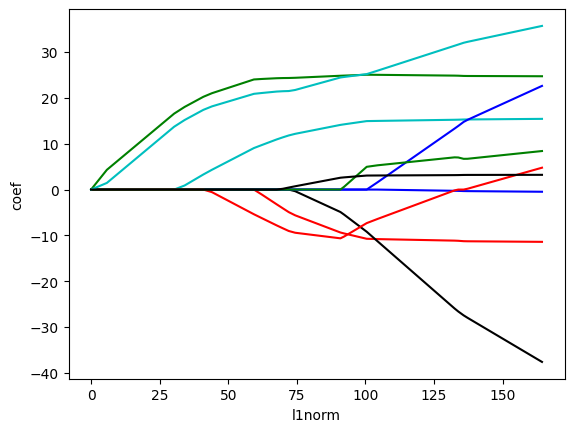

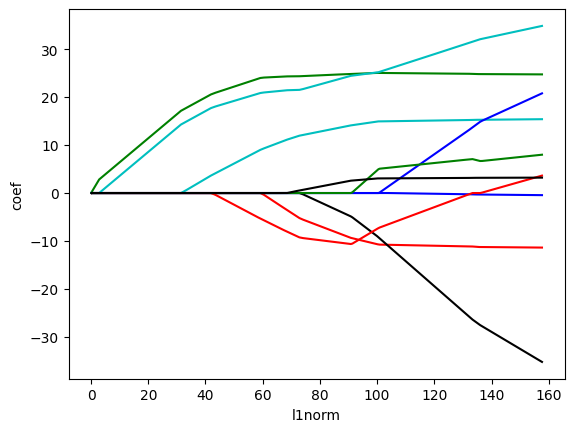

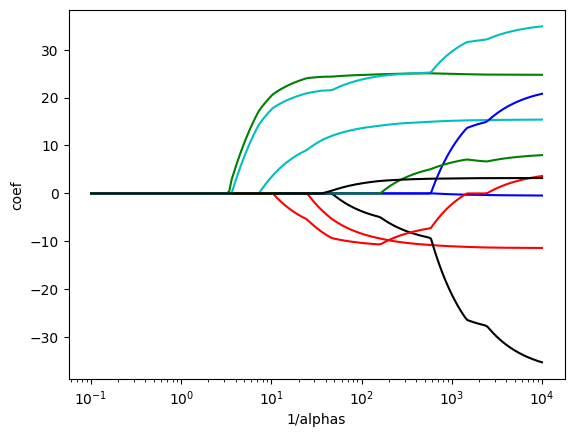

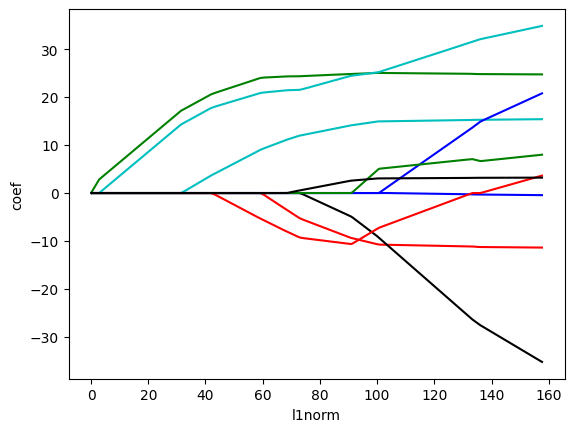

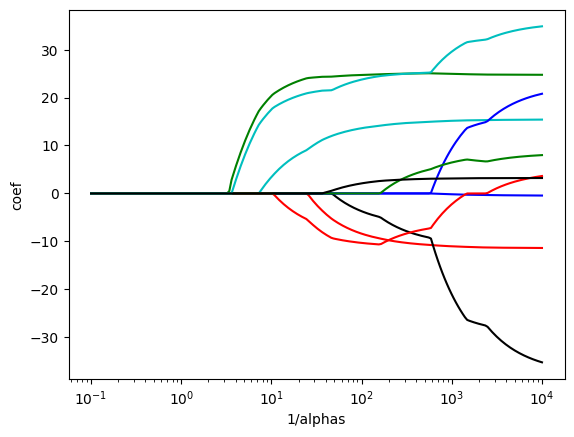

In [67]:
# test train_and_plot

X_diab, y_diab = datasets.load_diabetes(return_X_y=True)
# Standardize data
X_diab -= X_diab.mean(axis=0)
X_diab /= X_diab.std(axis=0)

## original lasso
fig_l, ax_l = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_diab, y_diab)
plot_coefs_l1norm(coefs_lasso, ax_l)

## Antonio's algo, 1 matrix
S_diab = np.eye(X_diab.shape[1])
fig, ax_1 = plt.subplots(1, 1, num='advtrain_linf_diab')
fig, ax_2 = plt.subplots(1, 1, num='advtrain_linf_diab_2')
train_and_plot(X_diab, y_diab, S_diab, [ax_1, ax_2])

## Antonio's algo, multiple matrices (same matrix stacked multiple time)
S_diab_stacked = np.array([S_diab] * X_diab.shape[0])
S_diab_stacked = np.concatenate(S_diab_stacked)
fig, ax_3 = plt.subplots(1, 1, num='advtrain_linf_diab_3')
fig, ax_4 = plt.subplots(1, 1, num='advtrain_linf_diab_4')
train_and_plot(X_diab, y_diab, S_diab_stacked, [ax_3, ax_4])




In [73]:
# test imputations

np.random.seed(45)


def test_imputations(n, d):
  X = np.random.randint(2, 5, size=(n, d)) * 1.0
  y = X @ np.random.randint(1, 3, size=d)
  m = np.random.binomial(1, 0.4, size=(n, d))  # 1 missing, 0 seen
  print("m original\n", m)
  X, y, m = clear_dataset(X, y, m)
  print(m)
  X_nan = X.copy()
  X_nan[m == 1] = np.nan

  #mask_from_xxx = np.isnan(xxx).astype(int)
  print("X\n ", X)
  print("masks \n", m)
  print("X_nan\n ", X_nan)
  methods = ['BR_si', 'mi', 'l_d']
  nbr_mi = [1, 3]
  #for method in methods:
  #  dict_info = {'imp_method': method, 'mi_nbr':nbr_mi}
  #dict_info = {'imp_method':methods, 'mi_nbr':nbr_mi}
  for method in methods:
    print("---------- method: ", method)
    if method == 'mi':
      for x in nbr_mi:
        print("-------------------- nbr mi: ", x)
        dict_info = {'imp_method':method, 'mi_nbr':x}
        #print("XNANNANAN ", X_nan)
        X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
        print(X_res, y_res, "\n", mask_res)
    else:
      dict_info = {'imp_method': method}
      X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
      print(X_res, y_res, "\n", mask_res)
    print("test imputations ended successfully")

test_imputations(6, 3)


m original
 [[1 1 0]
 [0 1 0]
 [1 0 1]
 [0 0 0]
 [0 1 1]
 [1 0 1]]
[[1 1 0]
 [0 1 0]
 [1 0 1]
 [0 0 0]
 [0 1 1]
 [1 0 1]]
X
  [[4. 2. 2.]
 [3. 3. 2.]
 [3. 2. 3.]
 [4. 3. 3.]
 [4. 2. 4.]
 [2. 3. 2.]]
masks 
 [[1 1 0]
 [0 1 0]
 [1 0 1]
 [0 0 0]
 [0 1 1]
 [1 0 1]]
X_nan
  [[nan nan  2.]
 [ 3. nan  2.]
 [nan  2. nan]
 [ 4.  3.  3.]
 [ 4. nan nan]
 [nan  3. nan]]
---------- method:  BR_si
[[3.6655945  2.66443243 2.        ]
 [3.         2.66258227 2.        ]
 [3.65923039 2.         0.01456084]
 [4.         3.         3.        ]
 [4.         2.66652472 2.0034846 ]
 [3.66880864 3.         3.00274305]] [ 8.  8.  8. 10. 10.  7.] 
 [[1 1 0]
 [0 1 0]
 [1 0 1]
 [0 0 0]
 [0 1 1]
 [1 0 1]]
test imputations ended successfully
---------- method:  mi
-------------------- nbr mi:  1
[[2.98022463 2.90457585 2.        ]
 [3.         4.05540778 2.        ]
 [3.20465199 2.         2.23294046]
 [4.         3.         3.        ]
 [4.         0.30437093 3.04480992]
 [3.02737436 3.         2.04467484]] [ 8. 

[array([1, 2]), array([1, 2]), array([1, 2])]
[[1 2]
 [1 2]
 [1 2]]
<class 'numpy.ndarray'>


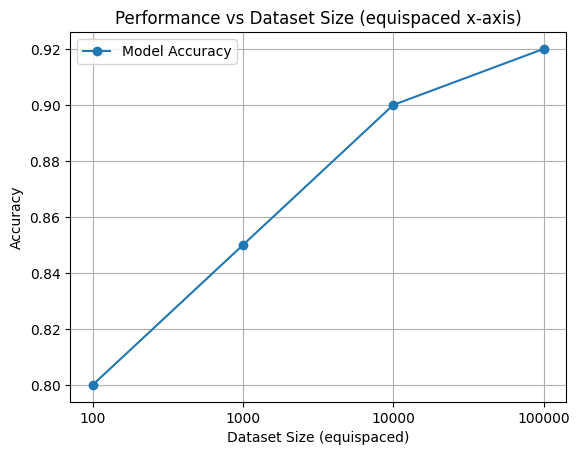

In [74]:
x = []
y = np.array([1, 2])
x.append(y)
x.append(y)
x.append(y)
xx = np.stack(x)
print(x)
print(xx)
print(type(xx))


import matplotlib.pyplot as plt

sizes = [100, 1000, 10000, 100000]
values = [0.8, 0.85, 0.9, 0.92]
positions = range(len(sizes))

plt.plot(positions, values, marker='o', label='Model Accuracy')  # Add label here
plt.xticks(positions, sizes)

plt.xlabel("Dataset Size (equispaced)")
plt.ylabel("Accuracy")
plt.title("Performance vs Dataset Size (equispaced x-axis)")
plt.legend()  # Show legend
plt.grid(True)
plt.show()



In [76]:

dictio = {'a':1, 'b':2, 'c':3}
vv = dictio.values()
#print(vv)
#print(vv[1])




